In [21]:
from datasets import load_dataset
import pandas as pd
import numpy as np

dataset = load_dataset("Adilbai/stock-dataset")
df = dataset["train"].to_pandas()

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"])

# Choose stock
ticker = "AAPL"
stock_df = df[df["Ticker"] == ticker].copy()

stock_df.reset_index(drop=True, inplace=True)


/tmp/ipykernel_204441/1882886443.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["Date"] = pd.to_datetime(df["Date"])


In [22]:
df["Ticker"].unique()[:20]
sp_df = df[df["Ticker"] == "^GSPC"][["Date", "Close"]]
sp_df = sp_df.rename(columns={"Close": "SP500_Close"})
stock_df = stock_df.merge(
    sp_df,
    on="Date",
    how="left"
)


In [23]:
#K_LIST = [260, 180, 150, 120, 100, 80, 60, 40, 20, 15, 10, 5, 1]
K_LIST = [120, 60, 40, 20, 10, 5, 1]


def compute_return(price, k):
    return (price - price.shift(k)) / price.shift(k)

feature enginnering.

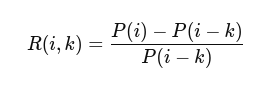

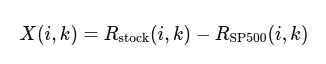

In [24]:
for k in K_LIST:
    stock_df[f"R_stock_{k}"] = compute_return(stock_df["Close"], k)
    stock_df[f"R_sp_{k}"] = compute_return(stock_df["SP500_Close"], k)
    stock_df[f"X_{k}"] = stock_df[f"R_stock_{k}"] - stock_df[f"R_sp_{k}"]

In [ ]:
feature_cols = [f"X_{k}" for k in K_LIST]
stock_df = stock_df.dropna(subset=feature_cols)



#print(feature_cols)

print(stock_df)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits, Ticker, SMA_5, SMA_10, SMA_20, SMA_50, EMA_12, EMA_26, MACD, MACD_Signal, MACD_Histogram, RSI, BB_Middle, BB_Upper, BB_Lower, BB_Width, BB_Position, Volatility, Price_Change, Price_Change_5d, High_Low_Ratio, Open_Close_Ratio, Volume_SMA, Volume_Ratio, Close_lag_1, Close_lag_2, Close_lag_3, Close_lag_5, Close_lag_10, Volume_lag_1, Volume_lag_2, Volume_lag_3, Volume_lag_5, Volume_lag_10, Price_Change_lag_1, Price_Change_lag_2, Price_Change_lag_3, Price_Change_lag_5, Price_Change_lag_10, RSI_lag_1, RSI_lag_2, RSI_lag_3, RSI_lag_5, RSI_lag_10, MACD_lag_1, MACD_lag_2, MACD_lag_3, MACD_lag_5, MACD_lag_10, Volatility_lag_1, Volatility_lag_2, Volatility_lag_3, Volatility_lag_5, Volatility_lag_10, Future_Return_1d, Future_Up_1d, Future_Category_1d, Future_Return_5d, Future_Up_5d, Future_Category_5d, Future_Return_10d, Future_Up_10d, Future_Category_10d, Future_Return_20d, Future_Up_20d, Future_Category_20d,

In [ ]:
THRESHOLD = 0.02  # 2%

future_returns = []

for i in range(len(stock_df)):
    future = stock_df.loc[i+1:i+10, "X_1"]
    future_returns.append(1 if (future >= THRESHOLD).any() else 0)

stock_df["label"] = future_returns
stock_df = stock_df.iloc[:-10]  # remove tail

stock_df = stock_df.dropna().reset_index(drop=True)

In [10]:
stock_df["label"].value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

Train test split/sliding window

In [11]:
TRAIN_DAYS = 253
TEST_DAYS = 21
GAP = 10

def sliding_windows(df):
    windows = []
    start = 0
    while start + TRAIN_DAYS + GAP + TEST_DAYS < len(df):
        train = df.iloc[start:start+TRAIN_DAYS]
        test = df.iloc[start+TRAIN_DAYS+GAP:
                       start+TRAIN_DAYS+GAP+TEST_DAYS]
        windows.append((train, test))
        start += TEST_DAYS
    return windows

windows = sliding_windows(stock_df)

#classical models
RF

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_accs = []

for train, test in windows:
    X_train = train[feature_cols].values
    y_train = train["label"].values
    X_test = test[feature_cols].values
    y_test = test["label"].values

    rf = RandomForestClassifier(
        n_estimators=1000,
        max_depth=5,
        max_features=13,
        random_state=42
    )
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    rf_accs.append(accuracy_score(y_test, preds))

print("RF mean accuracy:", np.mean(rf_accs))

RF mean accuracy: nan


/home/gurpreet/.conda/envs/lstm/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3824: RuntimeWarning: Mean of empty slice
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gurpreet/.conda/envs/lstm/lib/python3.11/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SVM

In [13]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svm_accs = []

for train, test in windows:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feature_cols])
    X_test = scaler.transform(test[feature_cols])

    y_train = train["label"]
    y_test = test["label"]

    svm = SVC(kernel="rbf", C=1.0)
    svm.fit(X_train, y_train)
    preds = svm.predict(X_test)
    svm_accs.append(accuracy_score(y_test, preds))

print("SVM mean accuracy:", np.mean(svm_accs))

SVM mean accuracy: nan


LSTM

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

SEQ_LEN = 20

def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

2026-02-08 15:24:49.330981: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-08 15:24:49.338700: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-08 15:24:49.610302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-08 15:24:50.548142: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

In [15]:
lstm_accs = []

for train, test in windows:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feature_cols])
    X_test = scaler.transform(test[feature_cols])

    y_train = train["label"].values
    y_test = test["label"].values

    X_train_seq, y_train_seq = make_sequences(X_train, y_train, SEQ_LEN)
    X_test_seq, y_test_seq = make_sequences(X_test, y_test, SEQ_LEN)

    model = Sequential([
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=64, verbose=0)
    preds = (model.predict(X_test_seq) > 0.5).astype(int)

    lstm_accs.append(accuracy_score(y_test_seq, preds))

print("LSTM mean accuracy:", np.mean(lstm_accs))

LSTM mean accuracy: nan


/home/gurpreet/.conda/envs/lstm/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3824: RuntimeWarning: Mean of empty slice
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gurpreet/.conda/envs/lstm/lib/python3.11/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
